## Requirements:

In [1]:
import gurobipy as gp
from gurobipy import GRB
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## Data:

In [2]:
"Loading the Solar Production Data"
data_dir = Path("./")
data_dir_DER_production = data_dir / "DER_production.json"
data_dir_DER_production = data_dir_DER_production.resolve()
with open(f"{data_dir_DER_production}", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Take the first row's hourly_profile_ratio list and make it a numpy array
Solar_CF = np.array(df["hourly_profile_ratio"][0])

In [3]:
print(f"Solar_CF: {Solar_CF}")

Solar_CF: [0.   0.   0.   0.   0.   0.05 0.14 0.21 0.15 0.12 0.21 0.25 0.85 0.75
 0.55 0.43 0.23 0.05 0.25 0.25 0.   0.   0.   0.  ]


In [4]:
"Fullt Flexible Load (FFL) Data"
# Load JSON filen
data_dir_usage_preferences = data_dir / "usage_preferences.json"
data_dir_usage_preferences = data_dir_usage_preferences.resolve()

with open(f"{data_dir_usage_preferences}", "r") as f:
    data = json.load(f)

    data
FFL_ref = data[0]["load_preferences"][0]["hourly_profile_ratio"]

In [5]:
print(f"FFL_ref: {FFL_ref}")


FFL_ref: [0.055, 0.04, 0.04, 0.04, 0.075, 0.48, 0.76, 0.8, 0.63, 0.22, 0.25, 0.35, 0.3, 0.28, 0.45, 0.65, 0.78, 0.9, 0.98, 0.88, 0.075, 0.15, 0.075, 0.055]


In [6]:
"Electrcity Markert Data"
data_dir_bus_params = data_dir / "bus_params.json"
data_dir_bus_params = data_dir_bus_params.resolve()

with open(f"{data_dir_bus_params}", "r") as f:
    data = json.load(f)

    data

electricity_price = data[0]["energy_price_DKK_per_kWh"]
price_import = data[0]["import_tariff_DKK/kWh"]
price_export = data[0]["export_tariff_DKK/kWh"]
#------------------------------------------
penalty_excess_import = data[0]["penalty_excess_import_DKK/kWh"]
penalty_excess_export = data[0]["penalty_excess_export_DKK/kWh"]
#-----------------------------------------------------
max_import = data[0]["max_import_kW"]
max_export = data[0]["max_export_kW"]

In [7]:
print(f"electricty_price: {electricity_price}")
print(f"price_import: {price_import}")
print(f"price_export: {price_export}")
print(f"penalty_excess_import: {penalty_excess_import}")
print(f"penalty_excess_export: {penalty_excess_export}")
print(f"max_import: {max_import}")
print(f"max_export: {max_export}")


electricty_price: [1.1, 1.05, 1.0, 0.9, 0.85, 1.01, 1.05, 1.2, 1.4, 1.6, 1.5, 1.1, 1.05, 1.0, 0.95, 1.0, 1.2, 1.5, 2.1, 2.5, 2.2, 1.8, 1.4, 1.2]
price_import: 0.5
price_export: 0.4
penalty_excess_import: 10
penalty_excess_export: 10
max_import: 1000
max_export: 500


In [8]:
"Ramping Up for Solar and FFL"
data_dir_appliance_params = data_dir / "appliance_params.json"
data_dir_appliance_params = data_dir_appliance_params.resolve()

with open(f"{data_dir_appliance_params}", "r") as f:
    data = json.load(f)

    data

max_power_solar = data["DER"][0]["max_power_kW"]
#min_power = data["DER"][0]["min_power_ratio"]
max_ramp_up_rate_solar = data["DER"][0]["max_ramp_rate_up_ratio"]
max_ramp_down_rate_solar = data["DER"][0]["max_ramp_rate_down_ratio"]
max_load_FFL = data["load"][0]["max_load_kWh_per_hour"]
min_load_FFL = data["load"][0]["min_load_ratio"]

max_ramp_up_rate_FFL= data["load"][0]["max_ramp_rate_up_ratio"]
max_ramp_down_rate_FFL= data["load"][0]["max_ramp_rate_down_ratio"]

In [9]:
print(f"max_power_solar: {max_power_solar}")
print(f"max_ramp_up_rate_solar: {max_ramp_up_rate_solar}")
print(f"max_ramp_down_rate_solar: {max_ramp_down_rate_solar}")
print(f"max_load_FFL: {max_load_FFL}")
print(f"min_load_FFL: {min_load_FFL}")
print(f"max_ramp_up_rate_FFL: {max_ramp_up_rate_FFL}")
print(f"max_ramp_down_rate_FFL: {max_ramp_down_rate_FFL}")


max_power_solar: 3.0
max_ramp_up_rate_solar: 1.0
max_ramp_down_rate_solar: 1.0
max_load_FFL: 3.0
min_load_FFL: 0.0
max_ramp_up_rate_FFL: 1.0
max_ramp_down_rate_FFL: 1.0


All units are in kW or KWh

In [10]:
t = range(len(Solar_CF))
t

range(0, 24)

In [11]:
"We set here Beta that will determine how conservative"
"will the model be with the deviation of the load of reference"
Beta = 0.5 # 0 <= Beta <= 1
#Beta = 0 --- IGNORE ---

## Optimization model:

In [12]:
# Create model
model = gp.Model("Prosumer_Optimization")

# Decision variables
x_imports = model.addVars(t, name="imported_power_kW", lb=0, ub=GRB.INFINITY)
x_exports = model.addVars(t, name="exported_power_kW", lb=0, ub=GRB.INFINITY)
x_FFL = model.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)  # scaled 0-1
z_import_excess = model.addVars(t, name="excess_import_kW", lb=0, ub=GRB.INFINITY)
z_export_excess = model.addVars(t, name="excess_export_kW", lb=0, ub=GRB.INFINITY)
#Auxiliary value for the deviation in the objective function
d = model.addVars(t, lb=0, name="deviation")

# Hourly binary variables for tariffs
y_import = model.addVars(t, vtype=GRB.BINARY, name="tariff_import_activation")
y_export = model.addVars(t, vtype=GRB.BINARY, name="tariff_export_activation")

# Hourly constraints
for i in t:
    # FFL min/max
    model.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL, name=f"FFL_min_{i}")
    model.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL, name=f"FFL_max_{i}")

    # Energy balance: generation + imports - exports = load
    model.addConstr(
        x_imports[i] - x_exports[i] + Solar_CF[i] * max_power_solar == x_FFL[i] * max_load_FFL,
        name=f"energy_balance_{i}"
    )

    # Excess import/export
    model.addConstr(z_import_excess[i] >= x_imports[i] - max_import, name=f"excess_import_{i}")
    model.addConstr(z_export_excess[i] >= x_exports[i] - max_export, name=f"excess_export_{i}")

    # Binary tariff activation (big-M constraints)
    model.addConstr(x_imports[i] <= max_import * y_import[i], name=f"import_limit_{i}")
    model.addConstr(x_exports[i] <= max_export * y_export[i], name=f"export_limit_{i}")

    # Ramp constraints for FFL
    if i > 0:
        model.addConstr(
            (x_FFL[i] * max_load_FFL) - (x_FFL[i-1] * max_load_FFL) <= max_ramp_up_rate_FFL * max_load_FFL,
            name=f"FFL_ramp_up_{i}"
        )
        model.addConstr(
            (x_FFL[i-1] * max_load_FFL) - (x_FFL[i] * max_load_FFL) <= max_ramp_down_rate_FFL * max_load_FFL,
            name=f"FFL_ramp_down_{i}"
        )
    #Auxiliary value for the deviation in the objective function
    model.addConstr(d[i] >= (x_FFL[i] - FFL_ref[i])*max_load_FFL, name=f"discomfort_pos{i}")
    model.addConstr(d[i] >= -(x_FFL[i] - FFL_ref[i])*max_load_FFL, name=f"discomfort_neg{i}")


# Objective: minimize cost + penalties + deviation from ref_load
model.setObjective(
    gp.quicksum(
        Beta * (
            (price_import + electricity_price[i]) * x_imports[i]
            + penalty_excess_import * z_import_excess[i]
            + (price_export - electricity_price[i]) * x_exports[i]
            + penalty_excess_export * z_export_excess[i]
        )
        + (1 - Beta) * d[i] * max_load_FFL
        for i in t
    ),
    sense=GRB.MINIMIZE
)
# Solve
model.optimize()



Set parameter Username
Set parameter LicenseID to value 2663265
Academic license - for non-commercial use only - expires 2026-05-10


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 262 rows, 192 columns and 500 nonzeros
Model fingerprint: 0xa322aa33
Variable types: 144 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-01, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+03]
Found heuristic solution: objective 32.5440000
Presolve removed 262 rows and 192 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 3: 16.7768 16.7768 32.544 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.677682500000e+01, best bound 1.677682500000e+01, gap 0.0000%


In [13]:

# Total FFL consumption over 24 hours
total_FFL = sum(x_FFL[i].X * max_load_FFL for i in t)
print("Total FFL consumption over 24h: {:.2f} kWh".format(total_FFL))

Total FFL consumption over 24h: 27.95 kWh


In [14]:
# Print results
print("Optimal objective value:", model.ObjVal)

for i in t:
    print(f"Hour {i}:")
    print(f"  Imported power = {x_imports[i].X:.2f} kW")
    print(f"  Exported power = {x_exports[i].X:.2f} kW")
    print(f"  FFL consumption = {x_FFL[i].X*max_load_FFL:.2f} kW")
    print(f"  FFL of reference = {FFL_ref[i]*max_load_FFL:.2f} kW")
    print(f"  Excess import = {z_import_excess[i].X:.2f} kW")
    print(f"  Excess export = {z_export_excess[i].X:.2f} kW")
    print(f"  Import tariff active = {int(y_import[i].X)}")
    print(f"  Export tariff active = {int(y_export[i].X)}")

Optimal objective value: 16.776825
Hour 0:
  Imported power = 0.17 kW
  Exported power = 0.00 kW
  FFL consumption = 0.17 kW
  FFL of reference = 0.17 kW
  Excess import = 0.00 kW
  Excess export = 0.00 kW
  Import tariff active = 1
  Export tariff active = 1
Hour 1:
  Imported power = 0.12 kW
  Exported power = 0.00 kW
  FFL consumption = 0.12 kW
  FFL of reference = 0.12 kW
  Excess import = 0.00 kW
  Excess export = 0.00 kW
  Import tariff active = 1
  Export tariff active = 1
Hour 2:
  Imported power = 0.12 kW
  Exported power = 0.00 kW
  FFL consumption = 0.12 kW
  FFL of reference = 0.12 kW
  Excess import = 0.00 kW
  Excess export = 0.00 kW
  Import tariff active = 1
  Export tariff active = 1
Hour 3:
  Imported power = 0.12 kW
  Exported power = 0.00 kW
  FFL consumption = 0.12 kW
  FFL of reference = 0.12 kW
  Excess import = 0.00 kW
  Excess export = 0.00 kW
  Import tariff active = 1
  Export tariff active = 1
Hour 4:
  Imported power = 0.22 kW
  Exported power = 0.00 kW
  F

In [15]:
# Still print the values for reference
print("Optimal objective value:", model.ObjVal)
for i in t:
    print(f"Hour {i}:")
    print(f"  FFL consumption = {x_FFL[i].X*max_load_FFL:.2f} kW / {FFL_ref[i]*max_load_FFL:.2f} kW")


Optimal objective value: 16.776825
Hour 0:
  FFL consumption = 0.17 kW / 0.17 kW
Hour 1:
  FFL consumption = 0.12 kW / 0.12 kW
Hour 2:
  FFL consumption = 0.12 kW / 0.12 kW
Hour 3:
  FFL consumption = 0.12 kW / 0.12 kW
Hour 4:
  FFL consumption = 0.22 kW / 0.22 kW
Hour 5:
  FFL consumption = 1.44 kW / 1.44 kW
Hour 6:
  FFL consumption = 2.28 kW / 2.28 kW
Hour 7:
  FFL consumption = 2.40 kW / 2.40 kW
Hour 8:
  FFL consumption = 1.89 kW / 1.89 kW
Hour 9:
  FFL consumption = 0.66 kW / 0.66 kW
Hour 10:
  FFL consumption = 0.75 kW / 0.75 kW
Hour 11:
  FFL consumption = 1.05 kW / 1.05 kW
Hour 12:
  FFL consumption = 0.90 kW / 0.90 kW
Hour 13:
  FFL consumption = 0.84 kW / 0.84 kW
Hour 14:
  FFL consumption = 1.35 kW / 1.35 kW
Hour 15:
  FFL consumption = 1.95 kW / 1.95 kW
Hour 16:
  FFL consumption = 2.34 kW / 2.34 kW
Hour 17:
  FFL consumption = 2.70 kW / 2.70 kW
Hour 18:
  FFL consumption = 2.94 kW / 2.94 kW
Hour 19:
  FFL consumption = 2.64 kW / 2.64 kW
Hour 20:
  FFL consumption = 0.22 k

## LP relaxation (to get duals):

In [16]:
# --- Solve LP relaxation (to get duals) ---
for v in model.getVars():
    if v.VType in (GRB.BINARY, GRB.INTEGER):
        v.VType = GRB.CONTINUOUS

model.optimize()

if model.Status == GRB.OPTIMAL:
    # Access duals directly by name
    for c in model.getConstrs():
        print(f"{c.ConstrName}: Pi = {c.Pi}")

# Print results and duals
print("Optimal objective value:", model.ObjVal)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 262 rows, 192 columns and 500 nonzeros
Model fingerprint: 0x524bf8fe
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-01, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 199 rows and 114 columns
Presolve time: 0.01s
Presolved: 63 rows, 78 columns, 141 nonzeros



Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5400000e+03   4.374129e+03   0.000000e+00      0s
      51    1.6776825e+01   0.000000e+00   0.000000e+00      0s

Solved in 51 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.677682500e+01
FFL_min_0: Pi = 0.0
FFL_max_0: Pi = 0.0
energy_balance_0: Pi = 0.8
excess_import_0: Pi = 0.0
excess_export_0: Pi = 0.0
import_limit_0: Pi = 0.0
export_limit_0: Pi = 0.0
discomfort_pos0: Pi = 0.0
discomfort_neg0: Pi = 0.8
FFL_min_1: Pi = 0.0
FFL_max_1: Pi = 0.0
energy_balance_1: Pi = 0.775
excess_import_1: Pi = 0.0
excess_export_1: Pi = 0.0
import_limit_1: Pi = 0.0
export_limit_1: Pi = 0.0
FFL_ramp_up_1: Pi = 0.0
FFL_ramp_down_1: Pi = 0.0
discomfort_pos1: Pi = 0.0
discomfort_neg1: Pi = 0.775
FFL_min_2: Pi = 0.0
FFL_max_2: Pi = 0.0
energy_balance_2: Pi = 0.75
excess_import_2: Pi = 0.0
excess_export_2: Pi = 0.0
import_limit_2: Pi = 0.0
export_limit_2: Pi = 0.0
FFL_ramp_up_2: Pi = 0.0
FFL_ramp_down_2: Pi = 0

In [17]:
"Dual Variables"

print(model.pi)
print(" ")
for constr in model.getConstrs():
    print(f"{constr.ConstrName}: dual = {constr.Pi}, slack = {constr.Slack}")

[0.0, 0.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.0, 0.775, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.775, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.0, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.675, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.675, 0.0, 0.0, 0.755, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.755, 0.0, 0.0, 0.775, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.775, 0.0, 0.0, 0.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.0, 0.95, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.95, 0.0, 0.0, 1.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.05, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.0, 0.325, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.325, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.27499999999999997, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27499999999999997, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.0, 0.0, 0.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.0, 

## Sensitivity analysis

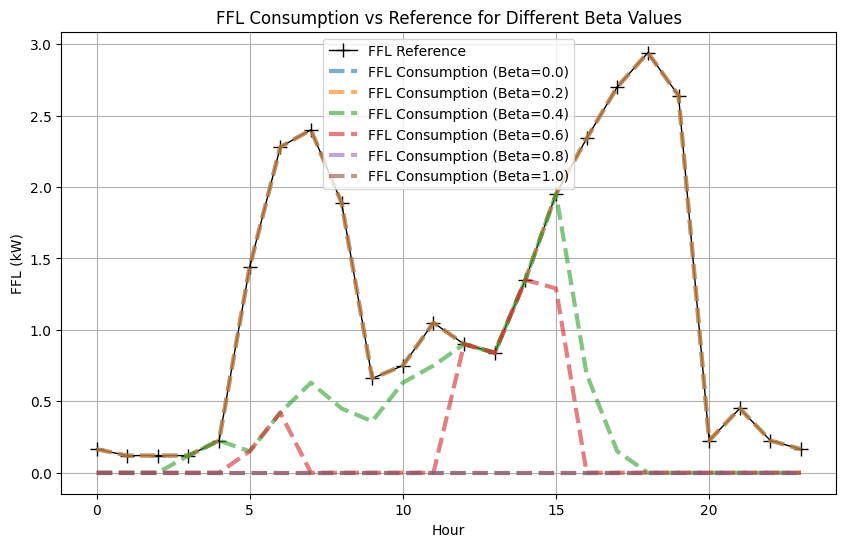

In [42]:
# Plot FFL consumption for different Beta values vs reference load
betas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # Example Beta values to test
ffl_results = []
for beta in betas:
    # Set Beta and re-run optimization
    model = gp.Model("Prosumer_Optimization")
    x_imports = model.addVars(t, name="imported_power_kW", lb=0, ub=GRB.INFINITY)
    x_exports = model.addVars(t, name="exported_power_kW", lb=0, ub=GRB.INFINITY)
    x_FFL = model.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)
    z_import_excess = model.addVars(t, name="excess_import_kW", lb=0, ub=GRB.INFINITY)
    z_export_excess = model.addVars(t, name="excess_export_kW", lb=0, ub=GRB.INFINITY)
    d = model.addVars(t, lb=0, name="deviation")
    y_import = model.addVars(t, vtype=GRB.BINARY, name="tariff_import_activation")
    y_export = model.addVars(t, vtype=GRB.BINARY, name="tariff_export_activation")
    for i in t:
        model.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL)
        model.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL)
        model.addConstr(x_imports[i] - x_exports[i] + Solar_CF[i] * max_power_solar == x_FFL[i] * max_load_FFL)
        model.addConstr(z_import_excess[i] >= x_imports[i] - max_import)
        model.addConstr(z_export_excess[i] >= x_exports[i] - max_export)
        model.addConstr(x_imports[i] <= max_import * y_import[i])
        model.addConstr(x_exports[i] <= max_export * y_export[i])
        if i > 0:
            model.addConstr((x_FFL[i] * max_load_FFL) - (x_FFL[i-1] * max_load_FFL) <= max_ramp_up_rate_FFL * max_load_FFL)
            model.addConstr((x_FFL[i-1] * max_load_FFL) - (x_FFL[i] * max_load_FFL) <= max_ramp_down_rate_FFL * max_load_FFL)
        model.addConstr(d[i] >= x_FFL[i] - FFL_ref[i])
        model.addConstr(d[i] >= -(x_FFL[i] - FFL_ref[i]))
    model.setObjective(
        gp.quicksum(
            beta * ((price_import + electricity_price[i]) * x_imports[i] + penalty_excess_import * z_import_excess[i] +
            (price_export - electricity_price[i]) * x_exports[i] + penalty_excess_export * z_export_excess[i]) +
            (1 - beta) * d[i] * max_load_FFL
            for i in t
        ),
        sense=GRB.MINIMIZE,
    )
    model.setParam('OutputFlag', 0)
    model.optimize()
    ffl_results.append([x_FFL[i].X * max_load_FFL for i in t])

# Plot all FFL consumptions for different Betas and the reference load
hours = list(t)
plt.figure(figsize=(10,6))
plt.plot(hours, [FFL_ref[i] * max_load_FFL for i in t], marker='+', markersize=10, color='black', label='FFL Reference', linewidth=1, alpha=1)
for idx, beta in enumerate(betas):
    plt.plot(hours, ffl_results[idx], linestyle='--', label=f'FFL Consumption (Beta={beta})', linewidth=3, alpha=0.6)
plt.xlabel('Hour')
plt.ylabel('FFL (kW)')
plt.title('FFL Consumption vs Reference for Different Beta Values')
plt.legend()
plt.grid(True)
plt.show()

### Solar consumption vs Solar maximum capacity (different betas)

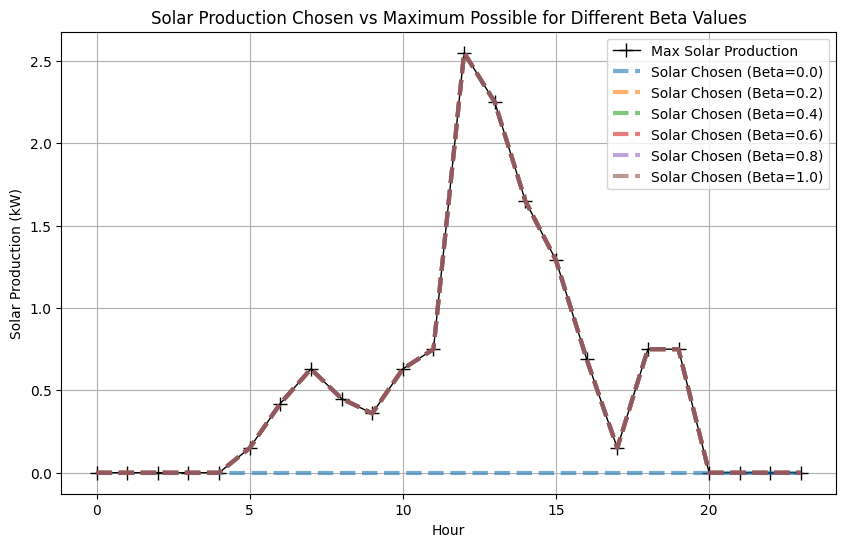

In [43]:
# Plot solar production chosen vs maximum possible for different Beta values
betas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # Example Beta values to test
solar_results = []
for beta in betas:
    model = gp.Model("Prosumer_Optimization_Solar")
    x_imports = model.addVars(t, name="imported_power_kW", lb=0, ub=GRB.INFINITY)
    x_exports = model.addVars(t, name="exported_power_kW", lb=0, ub=GRB.INFINITY)
    x_FFL = model.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)
    x_solar = model.addVars(t, name="solar_power_kW", lb=0)
    z_import_excess = model.addVars(t, name="excess_import_kW", lb=0, ub=GRB.INFINITY)
    z_export_excess = model.addVars(t, name="excess_export_kW", lb=0, ub=GRB.INFINITY)
    d = model.addVars(t, lb=0, name="deviation")
    y_import = model.addVars(t, vtype=GRB.BINARY, name="tariff_import_activation")
    y_export = model.addVars(t, vtype=GRB.BINARY, name="tariff_export_activation")
    for i in t:
        model.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL)
        model.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL)
        model.addConstr(x_solar[i] <= Solar_CF[i] * max_power_solar)
        model.addConstr(x_imports[i] - x_exports[i] + x_solar[i] == x_FFL[i] * max_load_FFL)
        model.addConstr(z_import_excess[i] >= x_imports[i] - max_import)
        model.addConstr(z_export_excess[i] >= x_exports[i] - max_export)
        model.addConstr(x_imports[i] <= max_import * y_import[i])
        model.addConstr(x_exports[i] <= max_export * y_export[i])
        if i > 0:
            model.addConstr((x_FFL[i] * max_load_FFL) - (x_FFL[i-1] * max_load_FFL) <= max_ramp_up_rate_FFL * max_load_FFL)
            model.addConstr((x_FFL[i-1] * max_load_FFL) - (x_FFL[i] * max_load_FFL) <= max_ramp_down_rate_FFL * max_load_FFL)
        model.addConstr(d[i] >= (x_FFL[i] - FFL_ref[i])*max_load_FFL)
        model.addConstr(d[i] >= -(x_FFL[i] - FFL_ref[i])*max_load_FFL)
    model.setObjective(
        gp.quicksum(
            beta * ((price_import + electricity_price[i]) * x_imports[i] + penalty_excess_import * z_import_excess[i] +
            (price_export - electricity_price[i]) * x_exports[i] + penalty_excess_export * z_export_excess[i]) +
            (1 - beta) * d[i] * max_load_FFL
            for i in t
        ),
        sense=GRB.MINIMIZE,
    )
    model.setParam('OutputFlag', 0)
    model.optimize()
    solar_results.append([x_solar[i].X for i in t])

# Plot all solar productions for different Betas and the maximum possible
hours = list(t)
plt.figure(figsize=(10,6))
plt.plot(hours, [Solar_CF[i] * max_power_solar for i in t], marker='+', markersize=10, color='black', label='Max Solar Production', linewidth=1, alpha=1)
for idx, beta in enumerate(betas):
    plt.plot(hours, solar_results[idx], linestyle='--', label=f'Solar Chosen (Beta={beta})', linewidth=3, alpha=0.6)
plt.xlabel('Hour')
plt.ylabel('Solar Production (kW)')
plt.title('Solar Production Chosen vs Maximum Possible for Different Beta Values')
plt.legend()
plt.grid(True)
plt.show()

### Objective value vs Beta

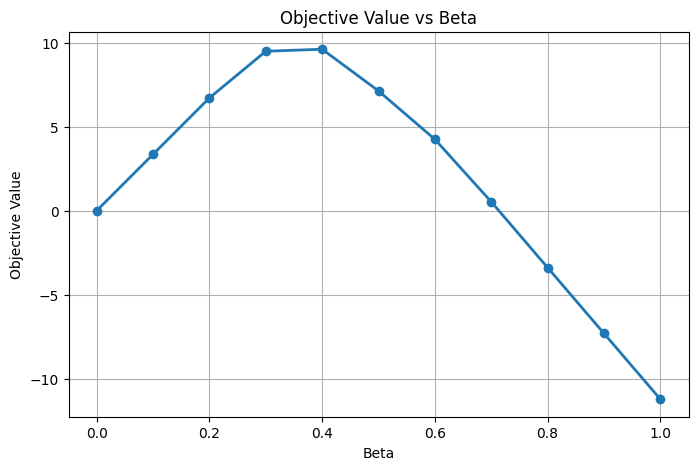

In [20]:
# Chart: Objective value vs Beta
betas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
objective_values = []
for beta in betas:
    model = gp.Model("Prosumer_Optimization_ObjVsBeta")
    x_imports = model.addVars(t, name="imported_power_kW", lb=0, ub=GRB.INFINITY)
    x_exports = model.addVars(t, name="exported_power_kW", lb=0, ub=GRB.INFINITY)
    x_FFL = model.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)
    z_import_excess = model.addVars(t, name="excess_import_kW", lb=0, ub=GRB.INFINITY)
    z_export_excess = model.addVars(t, name="excess_export_kW", lb=0, ub=GRB.INFINITY)
    d = model.addVars(t, lb=0, name="deviation")
    y_import = model.addVars(t, vtype=GRB.BINARY, name="tariff_import_activation")
    y_export = model.addVars(t, vtype=GRB.BINARY, name="tariff_export_activation")
    for i in t:
        model.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL)
        model.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL)
        model.addConstr(x_imports[i] - x_exports[i] + Solar_CF[i] * max_power_solar == x_FFL[i] * max_load_FFL)
        model.addConstr(z_import_excess[i] >= x_imports[i] - max_import)
        model.addConstr(z_export_excess[i] >= x_exports[i] - max_export)
        model.addConstr(x_imports[i] <= max_import * y_import[i])
        model.addConstr(x_exports[i] <= max_export * y_export[i])
        if i > 0:
            model.addConstr((x_FFL[i] * max_load_FFL) - (x_FFL[i-1] * max_load_FFL) <= max_ramp_up_rate_FFL * max_load_FFL)
            model.addConstr((x_FFL[i-1] * max_load_FFL) - (x_FFL[i] * max_load_FFL) <= max_ramp_down_rate_FFL * max_load_FFL)
        model.addConstr(d[i] >= (x_FFL[i] - FFL_ref[i]))
        model.addConstr(d[i] >= -(x_FFL[i] - FFL_ref[i]))
    model.setObjective(
        gp.quicksum(
            beta * (
                (price_import + electricity_price[i]) * x_imports[i]
                + penalty_excess_import * z_import_excess[i]
                + (price_export - electricity_price[i]) * x_exports[i]
                + penalty_excess_export * z_export_excess[i]
            )
            + (1 - beta) * d[i] * max_load_FFL
            for i in t
        ),
        sense=GRB.MINIMIZE
    )
    model.setParam('OutputFlag', 0)
    model.optimize()
    if model.Status == GRB.OPTIMAL:
        objective_values.append(model.ObjVal)
    else:
        objective_values.append(np.nan)
# Plot objective value vs Beta
plt.figure(figsize=(8,5))
plt.plot(betas, objective_values, marker='o', linewidth=2)
plt.xlabel('Beta')
plt.ylabel('Objective Value')
plt.title('Objective Value vs Beta')
plt.grid(True)
plt.show()

This results makes a lot of sense, because when Beta is equal to 0 you just care about sticking to the power reference, so you either get energy from the grid or from your solar panels but for sure you will meet the reuirement of the load reference. 
On the other hand if you dont care at all about the load reference you will sell all your energy to grid to make as much profit as possible, not wasting any energy in the load and for sure not wasting any money in energy imports

### Different parameters sensitivity for different betas

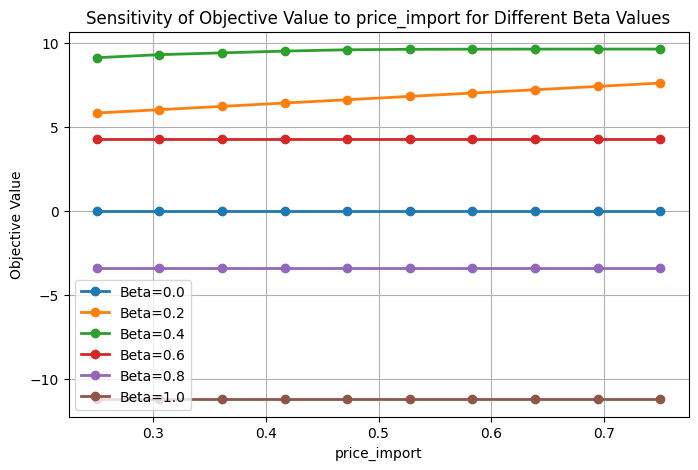

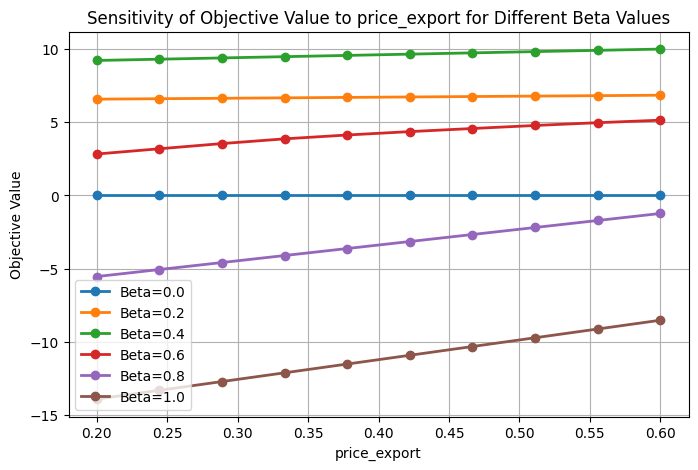

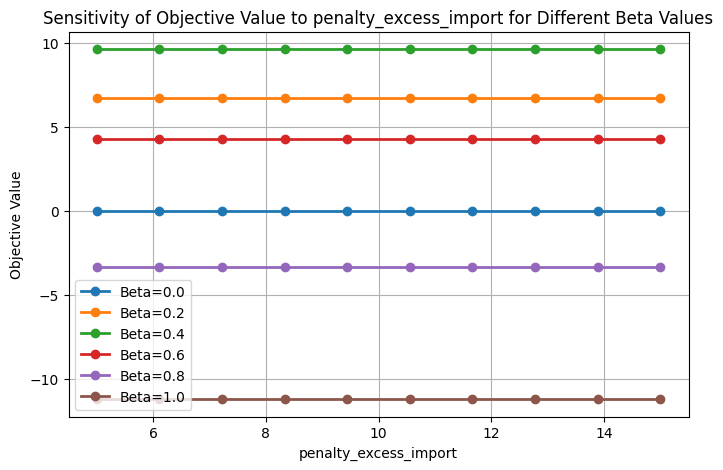

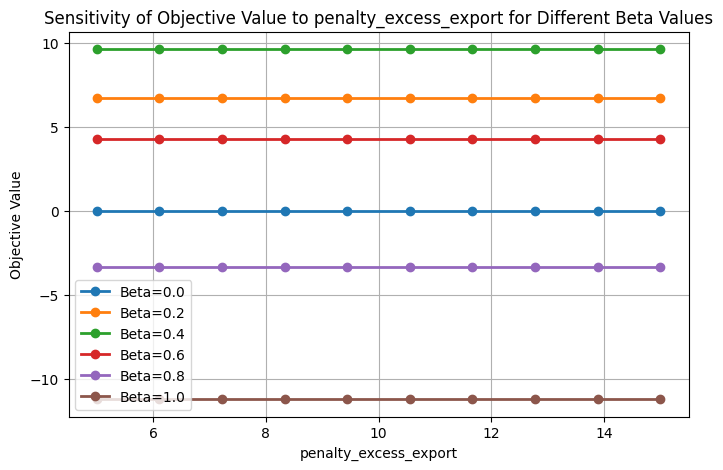

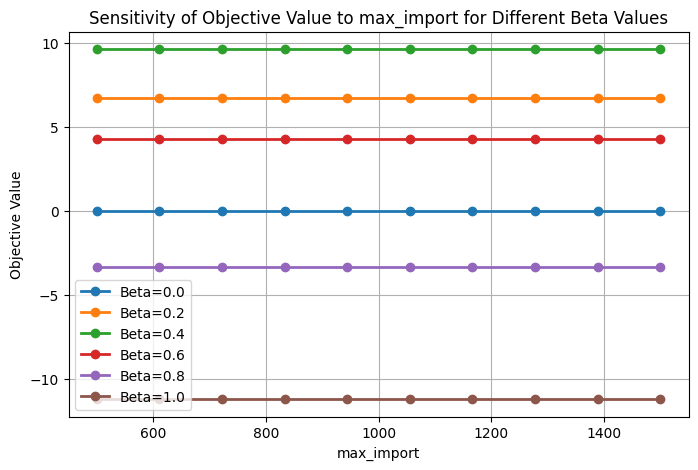

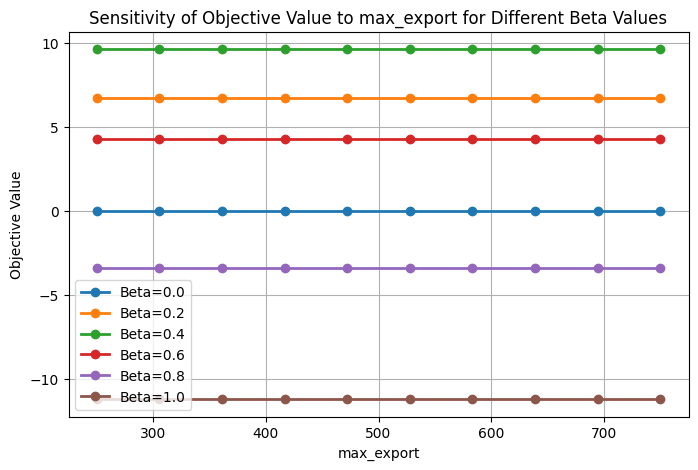

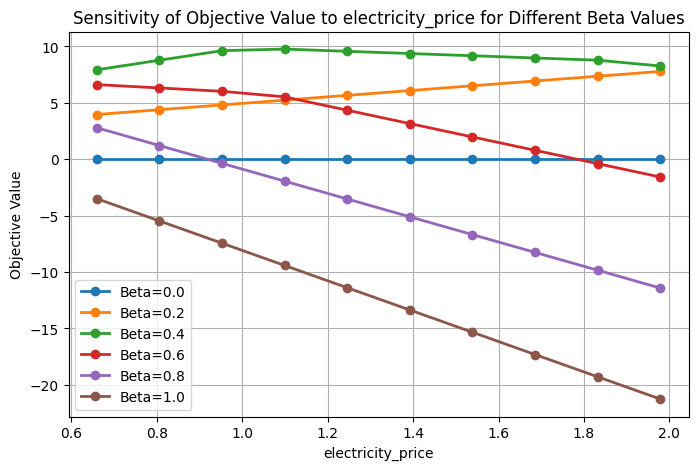

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def sensitivity_analysis_compare_beta(param_name, base_value, values, betas):
    results = {}
    for beta in betas:
        objective_values = []
        for val in values:
            # Set parameter values for this run
            pi = price_import if param_name != 'price_import' else val
            pe = price_export if param_name != 'price_export' else val
            pen_imp = penalty_excess_import if param_name != 'penalty_excess_import' else val
            pen_exp = penalty_excess_export if param_name != 'penalty_excess_export' else val
            mi = max_import if param_name != 'max_import' else val
            me = max_export if param_name != 'max_export' else val
            # For electricity_price, allow it to be a scalar or array
            if param_name == 'electricity_price':
                elec_price = [val]*len(t)
            else:
                elec_price = electricity_price
            # Create model
            model_sa = gp.Model("Prosumer_Optimization_SA")
            x_imports = model_sa.addVars(t, name="imported_power_kW", lb=0, ub=GRB.INFINITY)
            x_exports = model_sa.addVars(t, name="exported_power_kW", lb=0, ub=GRB.INFINITY)
            x_FFL = model_sa.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)
            z_import_excess = model_sa.addVars(t, name="excess_import_kW", lb=0, ub=GRB.INFINITY)
            z_export_excess = model_sa.addVars(t, name="excess_export_kW", lb=0, ub=GRB.INFINITY)
            d = model_sa.addVars(t, lb=0, name="deviation")
            y_import = model_sa.addVars(t, vtype=GRB.BINARY, name="tariff_import_activation")
            y_export = model_sa.addVars(t, vtype=GRB.BINARY, name="tariff_export_activation")
            for i in t:
                model_sa.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL)
                model_sa.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL)
                model_sa.addConstr(x_imports[i] - x_exports[i] + Solar_CF[i] * max_power_solar == x_FFL[i] * max_load_FFL)
                model_sa.addConstr(z_import_excess[i] >= x_imports[i] - mi)
                model_sa.addConstr(z_export_excess[i] >= x_exports[i] - me)
                model_sa.addConstr(x_imports[i] <= mi * y_import[i])
                model_sa.addConstr(x_exports[i] <= me * y_export[i])
                if i > 0:
                    model_sa.addConstr((x_FFL[i] * max_load_FFL) - (x_FFL[i-1] * max_load_FFL) <= max_ramp_up_rate_FFL * max_load_FFL)
                    model_sa.addConstr((x_FFL[i-1] * max_load_FFL) - (x_FFL[i] * max_load_FFL) <= max_ramp_down_rate_FFL * max_load_FFL)
                model_sa.addConstr(d[i] >= x_FFL[i] - FFL_ref[i])
                model_sa.addConstr(d[i] >= -(x_FFL[i] - FFL_ref[i]))
            model_sa.setObjective(
                gp.quicksum(
                    beta * ((pi + elec_price[i]) * x_imports[i] 
                            + pen_imp * z_import_excess[i] 
                            + (pe - elec_price[i]) * x_exports[i] 
                            + pen_exp * z_export_excess[i]
                        ) 
                    + (1-beta) * d[i] * max_load_FFL
                    for i in t
                ),
                sense=GRB.MINIMIZE
            )
            model_sa.setParam('OutputFlag', 0)
            model_sa.optimize()
            if model_sa.Status == GRB.OPTIMAL:
                objective_values.append(model_sa.ObjVal)
            else:
                objective_values.append(np.nan)
        results[beta] = objective_values
    plt.figure(figsize=(8,5))
    for beta in betas:
        plt.plot(values, results[beta], marker='o', label=f'Beta={beta}', linewidth=2)
    plt.xlabel(param_name)
    plt.ylabel('Objective Value')
    plt.title(f'Sensitivity of Objective Value to {param_name} for Different Beta Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define Beta values to compare
betas_to_compare = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Sensitivity for each parameter compared across Beta values
sensitivity_analysis_compare_beta('price_import', price_import, np.linspace(price_import*0.5, price_import*1.5, 10), betas_to_compare)
sensitivity_analysis_compare_beta('price_export', price_export, np.linspace(price_export*0.5, price_export*1.5, 10), betas_to_compare)
sensitivity_analysis_compare_beta('penalty_excess_import', penalty_excess_import, np.linspace(penalty_excess_import*0.5, penalty_excess_import*1.5, 10), betas_to_compare)
sensitivity_analysis_compare_beta('penalty_excess_export', penalty_excess_export, np.linspace(penalty_excess_export*0.5, penalty_excess_export*1.5, 10), betas_to_compare)
sensitivity_analysis_compare_beta('max_import', max_import, np.linspace(max_import*0.5, max_import*1.5, 10), betas_to_compare)
sensitivity_analysis_compare_beta('max_export', max_export, np.linspace(max_export*0.5, max_export*1.5, 10), betas_to_compare)
sensitivity_analysis_compare_beta('electricity_price', np.mean(electricity_price), np.linspace(np.mean(electricity_price)*0.5, np.mean(electricity_price)*1.5, 10), betas_to_compare)

### Different parameters sensitivity comparison (+-10%,+-25%) (same beta)

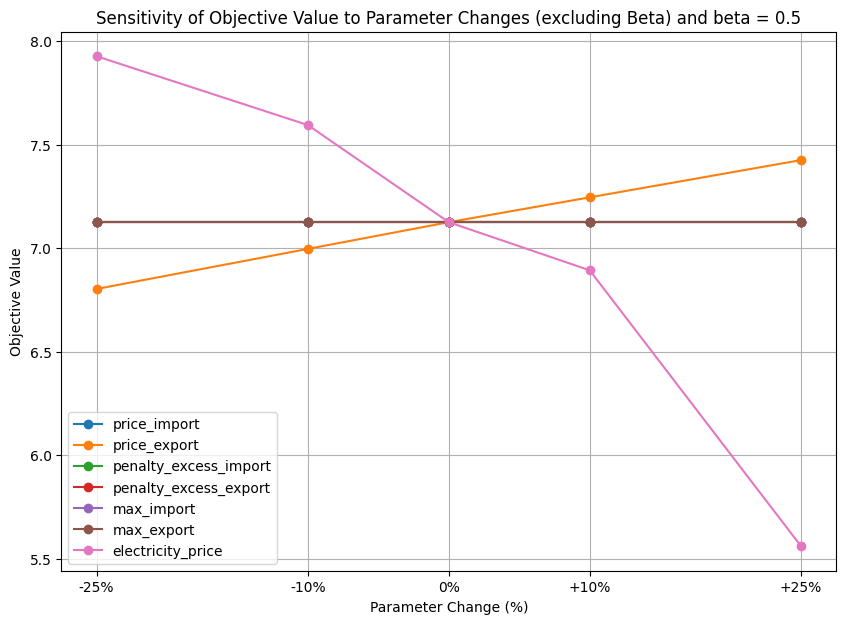

In [22]:
params = [
    ('price_import', price_import),
    ('price_export', price_export),
    ('penalty_excess_import', penalty_excess_import),
    ('penalty_excess_export', penalty_excess_export),
    ('max_import', max_import),
    ('max_export', max_export),
    ('electricity_price', np.mean(electricity_price))
    # Beta is excluded from this chart
 ]

percent_changes = [-0.25, -0.10, 0, 0.10, 0.25]

results = {}

for param_name, base_value in params:
    values = [base_value * (1 + p) for p in percent_changes]
    objective_values = []
    for idx, val in enumerate(values):
        pi = price_import if param_name != 'price_import' else val
        pe = price_export if param_name != 'price_export' else val
        pen_imp = penalty_excess_import if param_name != 'penalty_excess_import' else val
        pen_exp = penalty_excess_export if param_name != 'penalty_excess_export' else val
        mi = max_import if param_name != 'max_import' else val
        me = max_export if param_name != 'max_export' else val
        beta = Beta
        # For electricity_price, use true hourly array at 0% change, otherwise scale the array
        if param_name == 'electricity_price':
            if percent_changes[idx] == 0:
                elec_price = electricity_price
            else:
                elec_price = [base_value * (1 + percent_changes[idx])] * len(t)
        else:
            elec_price = electricity_price
        model_sa = gp.Model("Prosumer_Optimization_SA")
        x_imports = model_sa.addVars(t, name="imported_power_kW", lb=0, ub=GRB.INFINITY)
        x_exports = model_sa.addVars(t, name="exported_power_kW", lb=0, ub=GRB.INFINITY)
        x_FFL = model_sa.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)
        z_import_excess = model_sa.addVars(t, name="excess_import_kW", lb=0, ub=GRB.INFINITY)
        z_export_excess = model_sa.addVars(t, name="excess_export_kW", lb=0, ub=GRB.INFINITY)
        d = model_sa.addVars(t, lb=0, name="deviation")
        y_import = model_sa.addVars(t, vtype=GRB.BINARY, name="tariff_import_activation")
        y_export = model_sa.addVars(t, vtype=GRB.BINARY, name="tariff_export_activation")
        for i in t:
            model_sa.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL)
            model_sa.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL)
            model_sa.addConstr(x_imports[i] - x_exports[i] + Solar_CF[i] * max_power_solar == x_FFL[i] * max_load_FFL)
            model_sa.addConstr(z_import_excess[i] >= x_imports[i] - mi)
            model_sa.addConstr(z_export_excess[i] >= x_exports[i] - me)
            model_sa.addConstr(x_imports[i] <= mi * y_import[i])
            model_sa.addConstr(x_exports[i] <= me * y_export[i])
            if i > 0:
                model_sa.addConstr((x_FFL[i] * max_load_FFL) - (x_FFL[i-1] * max_load_FFL) <= max_ramp_up_rate_FFL * max_load_FFL)
                model_sa.addConstr((x_FFL[i-1] * max_load_FFL) - (x_FFL[i] * max_load_FFL) <= max_ramp_down_rate_FFL * max_load_FFL)
            model_sa.addConstr(d[i] >= x_FFL[i] - FFL_ref[i])
            model_sa.addConstr(d[i] >= -(x_FFL[i] - FFL_ref[i]))
        # Updated objective function to include electricity price as in main model
        model_sa.setObjective(
            gp.quicksum(
                Beta * ((pi + elec_price[i]) * x_imports[i] + pen_imp * z_import_excess[i] +
                (pe - elec_price[i]) * x_exports[i] + pen_exp * z_export_excess[i]) +
                (1 - Beta) * d[i] * max_load_FFL
                for i in t
            ),
            sense=GRB.MINIMIZE,
        )
        model_sa.setParam('OutputFlag', 0)
        model_sa.optimize()
        if model_sa.Status == GRB.OPTIMAL:
            objective_values.append(model_sa.ObjVal)
        else:
            objective_values.append(np.nan)
    results[param_name] = (base_value, percent_changes, objective_values)

plt.figure(figsize=(10,7))
for param_name, (base_value, percent_changes, obj_vals) in results.items():
    plt.plot(percent_changes, obj_vals, marker='o', label=param_name)
plt.xticks(percent_changes, ['-25%', '-10%', '0%', '+10%', '+25%'])
plt.xlabel('Parameter Change (%)')
plt.ylabel('Objective Value')
plt.title(f'Sensitivity of Objective Value to Parameter Changes (excluding Beta) and beta = {Beta}')
plt.legend()
plt.grid(True)
plt.show()